In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


images_dir = "patches/images"
masks_dir = "patches/masks"

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".png")])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(".png")])
num_images = len(image_files)
assert num_images == len(mask_files), "Different number of images and masks!"

def get_index(filename, prefix):
    return int(filename.replace(prefix, "").split(".")[0])

image_files = sorted(image_files, key=lambda x: get_index(x, "img_"))
mask_files = sorted(mask_files, key=lambda x: get_index(x, "mask_"))

image_paths = [os.path.join(images_dir, fname) for fname in image_files]
mask_paths = [os.path.join(masks_dir, fname) for fname in mask_files]


filtered = [(img, msk) for img, msk in zip(image_paths, mask_paths)
            if np.mean(np.array(Image.open(msk).convert("L")) > 0) > 0.005]
image_paths, mask_paths = zip(*filtered)
image_paths, mask_paths = list(image_paths), list(mask_paths)

indices = list(range(len(image_paths)))
random.shuffle(indices)
train_end = int(0.8 * len(indices))
val_end = int(0.9 * len(indices))
train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]


class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L").resize((128, 128))
        mask = Image.open(self.mask_paths[idx]).convert("L").resize((128, 128))
        if self.augment:
            if random.random() < 0.5:
                image, mask = ImageOps.mirror(image), ImageOps.mirror(mask)
            if random.random() < 0.5:
                image, mask = ImageOps.flip(image), ImageOps.flip(mask)
            angle = random.uniform(-10, 10)
            if abs(angle) > 1e-3:
                image = image.rotate(angle, resample=Image.BILINEAR, fillcolor=0)
                mask = mask.rotate(angle, resample=Image.NEAREST, fillcolor=0)
        image_tensor = T.ToTensor()(image)
        mask_tensor = (T.ToTensor()(mask) > 0.5).float()
        return image_tensor, mask_tensor


batch_size = 2  
train_dataset = SegmentationDataset([image_paths[i] for i in train_indices],
                                    [mask_paths[i] for i in train_indices], augment=False)
val_dataset = SegmentationDataset([image_paths[i] for i in val_indices],
                                  [mask_paths[i] for i in val_indices], augment=False)
test_dataset = SegmentationDataset([image_paths[i] for i in test_indices],
                                   [mask_paths[i] for i in test_indices], augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU()
        )
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.conv1 = DoubleConv(in_channels, 32)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        self.conv4 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv_up3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv_up2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.conv_up1 = DoubleConv(64, 32)
        self.out_conv = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv_up3(x)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv_up2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv_up1(x)
        return torch.sigmoid(self.out_conv(x))


bce_loss_fn = nn.BCELoss()
def loss_function(pred, target):
    bce = bce_loss_fn(pred, target)
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    smooth = 1e-5
    dice_coeff = (2 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    dice_loss = 1 - dice_coeff
    return bce + dice_loss

def dice_coef(pred, target):
    pred_bin = (pred >= 0.5).float()
    target_bin = (target >= 0.5).float()
    intersection = (pred_bin * target_bin).sum(dim=[1,2,3])
    pred_sum = pred_bin.sum(dim=[1,2,3])
    target_sum = target_bin.sum(dim=[1,2,3])
    dice = (2 * intersection + 1e-5) / (pred_sum + target_sum + 1e-5)
    no_positive = (pred_sum == 0) & (target_sum == 0)
    if torch.any(no_positive):
        dice = dice.clone()
        dice[no_positive] = 1.0
    return dice.mean()

def iou_coef(pred, target):
    pred_bin = (pred >= 0.5).float()
    target_bin = (target >= 0.5).float()
    intersection = (pred_bin * target_bin).sum(dim=[1,2,3])
    union = (pred_bin + target_bin).clamp(max=1).sum(dim=[1,2,3])
    iou = (intersection + 1e-5) / (union + 1e-5)
    empty = (union == 0)
    if torch.any(empty):
        iou = iou.clone()
        iou[empty] = 1.0
    return iou.mean()

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
best_dice, best_epoch = 0, -1

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_function(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    val_dice_total, val_iou_total, val_count = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            batch_dice = dice_coef(preds, masks)
            batch_iou = iou_coef(preds, masks)
            val_dice_total += batch_dice.item() * imgs.size(0)
            val_iou_total += batch_iou.item() * imgs.size(0)
            val_count += imgs.size(0)
    avg_val_dice = val_dice_total / val_count
    avg_val_iou = val_iou_total / val_count

    print(f"Epoch {epoch}/{num_epochs} — Loss: {epoch_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val IoU: {avg_val_iou:.4f}")

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")
        print(f"[SAVE] Лучшие веса сохранены (эпоха {epoch}, Dice={best_dice:.4f})")

print(f"Обучение завершено. Лучшая модель: эпоха {best_epoch} с Dice={best_dice:.4f}.")





GPU: NVIDIA GeForce RTX 4070
Epoch 1/20 — Loss: 0.5430 | Val Dice: 0.7080 | Val IoU: 0.5806
[SAVE] Лучшие веса сохранены (эпоха 1, Dice=0.7080)
Epoch 2/20 — Loss: 0.4042 | Val Dice: 0.7348 | Val IoU: 0.6123
[SAVE] Лучшие веса сохранены (эпоха 2, Dice=0.7348)
Epoch 3/20 — Loss: 0.3759 | Val Dice: 0.7413 | Val IoU: 0.6205
[SAVE] Лучшие веса сохранены (эпоха 3, Dice=0.7413)
Epoch 4/20 — Loss: 0.3537 | Val Dice: 0.7510 | Val IoU: 0.6329
[SAVE] Лучшие веса сохранены (эпоха 4, Dice=0.7510)
Epoch 5/20 — Loss: 0.3489 | Val Dice: 0.7572 | Val IoU: 0.6400
[SAVE] Лучшие веса сохранены (эпоха 5, Dice=0.7572)
Epoch 6/20 — Loss: 0.3421 | Val Dice: 0.7622 | Val IoU: 0.6453
[SAVE] Лучшие веса сохранены (эпоха 6, Dice=0.7622)
Epoch 7/20 — Loss: 0.3376 | Val Dice: 0.7646 | Val IoU: 0.6490
[SAVE] Лучшие веса сохранены (эпоха 7, Dice=0.7646)
Epoch 8/20 — Loss: 0.3354 | Val Dice: 0.7583 | Val IoU: 0.6426
Epoch 9/20 — Loss: 0.3295 | Val Dice: 0.7669 | Val IoU: 0.6520
[SAVE] Лучшие веса сохранены (эпоха 9, D

In [ ]:
import torch
import torch.nn as nn
from PIL import Image, ImageOps
import numpy as np
from torchvision import transforms as T


class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU()
        )
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.conv1 = DoubleConv(in_channels, 32)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        self.conv4 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv_up3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv_up2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.conv_up1 = DoubleConv(64, 32)
        self.out_conv = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv_up3(x)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv_up2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv_up1(x)
        return torch.sigmoid(self.out_conv(x))


def predict_full_image(model, image_path, patch_size=128):
    model.eval()
    device = next(model.parameters()).device
    full_img = Image.open(image_path).convert("L")
    orig_width, orig_height = full_img.size
    pad_w = (patch_size - orig_width % patch_size) if orig_width % patch_size != 0 else 0
    pad_h = (patch_size - orig_height % patch_size) if orig_height % patch_size != 0 else 0
    if pad_w != 0 or pad_h != 0:
        full_img = ImageOps.expand(full_img, border=(0, 0, pad_w, pad_h), fill=0)
    new_width, new_height = full_img.size
    full_mask = np.zeros((new_height, new_width), dtype=np.float32)
    nx = new_width // patch_size
    ny = new_height // patch_size
    for iy in range(ny):
        for ix in range(nx):
            x0 = ix * patch_size
            y0 = iy * patch_size
            patch = full_img.crop((x0, y0, x0 + patch_size, y0 + patch_size))
            patch_tensor = T.ToTensor()(patch).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_patch = model(patch_tensor)
            pred_patch = pred_patch.cpu().numpy().squeeze()
            full_mask[y0:y0 + patch_size, x0:x0 + patch_size] = pred_patch
    full_mask = full_mask[:orig_height, :orig_width]
    return full_mask


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()


full_image_path = "proto.png"


predicted_mask = predict_full_image(model, full_image_path, patch_size=128)
predicted_mask_bin = (predicted_mask >= 0.5).astype(np.uint8) * 255


Image.fromarray(predicted_mask_bin).save("segmentation_result_u_net.png")
print("Готово! Результат сохранён в segmentation_result_u_net.png")


Готово! Результат сохранён в segmentation_result.png


In [1]:
import os, random, numpy as np
from PIL import Image, ImageOps
import torch, torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import directed_hausdorff

random.seed(42); np.random.seed(42); torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda": print("GPU:", torch.cuda.get_device_name(0))

images_dir = "patches/images"
masks_dir = "patches/masks"
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".png")])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(".png")])
def get_index(filename, prefix): return int(filename.replace(prefix, "").split(".")[0])
image_files = sorted(image_files, key=lambda x: get_index(x, "img_"))
mask_files = sorted(mask_files, key=lambda x: get_index(x, "mask_"))
image_paths = [os.path.join(images_dir, fname) for fname in image_files]
mask_paths = [os.path.join(masks_dir, fname) for fname in mask_files]
filtered = [(img, msk) for img, msk in zip(image_paths, mask_paths)
            if np.mean(np.array(Image.open(msk).convert("L")) > 0) > 0.005]
image_paths, mask_paths = zip(*filtered)
image_paths, mask_paths = list(image_paths), list(mask_paths)
indices = list(range(len(image_paths)))
random.shuffle(indices)
train_end = int(0.8 * len(indices)); val_end = int(0.9 * len(indices))
train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False):
        self.image_paths = image_paths; self.mask_paths = mask_paths; self.augment = augment
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L").resize((128, 128))
        mask = Image.open(self.mask_paths[idx]).convert("L").resize((128, 128))
        if self.augment:
            if random.random() < 0.5: image, mask = ImageOps.mirror(image), ImageOps.mirror(mask)
            if random.random() < 0.5: image, mask = ImageOps.flip(image), ImageOps.flip(mask)
            angle = random.uniform(-10, 10)
            if abs(angle) > 1e-3:
                image = image.rotate(angle, resample=Image.BILINEAR, fillcolor=0)
                mask = mask.rotate(angle, resample=Image.NEAREST, fillcolor=0)
        image_tensor = T.ToTensor()(image)
        mask_tensor = (T.ToTensor()(mask) > 0.5).float()
        return image_tensor, mask_tensor

batch_size = 2
train_dataset = SegmentationDataset([image_paths[i] for i in train_indices], [mask_paths[i] for i in train_indices], augment=False)
val_dataset   = SegmentationDataset([image_paths[i] for i in val_indices], [mask_paths[i] for i in val_indices], augment=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU())
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.conv1 = DoubleConv(in_channels, 32)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        self.conv4 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv_up3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv_up2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.conv_up1 = DoubleConv(64, 32)
        self.out_conv = nn.Conv2d(32, out_channels, 1)
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x = self.up3(x4); x = torch.cat([x, x3], dim=1); x = self.conv_up3(x)
        x = self.up2(x); x = torch.cat([x, x2], dim=1); x = self.conv_up2(x)
        x = self.up1(x); x = torch.cat([x, x1], dim=1); x = self.conv_up1(x)
        return torch.sigmoid(self.out_conv(x))

bce_loss_fn = nn.BCELoss()
def loss_function(pred, target):
    bce = bce_loss_fn(pred, target)
    pred_flat = pred.view(-1); target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum(); smooth = 1e-5
    dice_coeff = (2 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    dice_loss = 1 - dice_coeff
    return bce + dice_loss

def dice_coef(pred, target):
    pred_bin = (pred >= 0.5).float(); target_bin = (target >= 0.5).float()
    intersection = (pred_bin * target_bin).sum(dim=[1,2,3])
    pred_sum = pred_bin.sum(dim=[1,2,3]); target_sum = target_bin.sum(dim=[1,2,3])
    dice = (2 * intersection + 1e-5) / (pred_sum + target_sum + 1e-5)
    no_positive = (pred_sum == 0) & (target_sum == 0)
    if torch.any(no_positive): dice = dice.clone(); dice[no_positive] = 1.0
    return dice.mean()

def iou_coef(pred, target):
    pred_bin = (pred >= 0.5).float(); target_bin = (target >= 0.5).float()
    intersection = (pred_bin * target_bin).sum(dim=[1,2,3])
    union = (pred_bin + target_bin).clamp(max=1).sum(dim=[1,2,3])
    iou = (intersection + 1e-5) / (union + 1e-5)
    empty = (union == 0)
    if torch.any(empty): iou = iou.clone(); iou[empty] = 1.0
    return iou.mean()

def pixel_accuracy(pred, target):
    pred_bin = (pred >= 0.5).float(); target_bin = (target >= 0.5).float()
    correct = (pred_bin == target_bin).float().sum(); total = pred_bin.numel()
    return correct / total

def hausdorff_distance(pred, target):
    pred_bin = (pred >= 0.5).cpu().numpy().astype(np.uint8)
    target_bin = (target >= 0.5).cpu().numpy().astype(np.uint8)
    hd_list = []
    for i in range(pred_bin.shape[0]):
        p_points = np.argwhere(pred_bin[i,0]); t_points = np.argwhere(target_bin[i,0])
        if len(p_points) == 0 or len(t_points) == 0: hd = np.nan
        else:
            hd1 = directed_hausdorff(p_points, t_points)[0]
            hd2 = directed_hausdorff(t_points, p_points)[0]
            hd = max(hd1, hd2)
        hd_list.append(hd)
    hd_list = [h for h in hd_list if not np.isnan(h)]
    return np.mean(hd_list) if hd_list else np.nan

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20
best_dice, best_epoch = 0, -1

history = {'train_loss': [], 'val_dice': [], 'val_iou': [], 'val_acc': [], 'val_hausdorff': []}

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_function(preds, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    model.eval()
    val_dice_total, val_iou_total, val_acc_total, val_hausdorff_total, val_count = 0, 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            batch_dice = dice_coef(preds, masks)
            batch_iou = iou_coef(preds, masks)
            batch_acc = pixel_accuracy(preds, masks)
            batch_hausdorff = hausdorff_distance(preds, masks)
            val_dice_total += batch_dice.item() * imgs.size(0)
            val_iou_total += batch_iou.item() * imgs.size(0)
            val_acc_total += batch_acc.item() * imgs.size(0)
            val_hausdorff_total += batch_hausdorff * imgs.size(0)
            val_count += imgs.size(0)
    avg_val_dice = val_dice_total / val_count
    avg_val_iou = val_iou_total / val_count
    avg_val_acc = val_acc_total / val_count
    avg_val_hausdorff = val_hausdorff_total / val_count

    print(f"Epoch {epoch}/{num_epochs} — Loss: {epoch_loss:.4f} | Dice: {avg_val_dice:.4f} | IoU: {avg_val_iou:.4f} | Acc: {avg_val_acc:.4f} | Hausdorff: {avg_val_hausdorff:.2f}")

    history['train_loss'].append(epoch_loss)
    history['val_dice'].append(avg_val_dice)
    history['val_iou'].append(avg_val_iou)
    history['val_acc'].append(avg_val_acc)
    history['val_hausdorff'].append(avg_val_hausdorff)

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice; best_epoch = epoch
        torch.save(model.state_dict(), "best_model1.pth")
        print(f"[SAVE] Лучшие веса сохранены (эпоха {epoch}, Dice={best_dice:.4f})")

print(f"Обучение завершено. Лучшая модель: эпоха {best_epoch} с Dice={best_dice:.4f}.")

import pickle
with open("training_history.pkl", "wb") as f:
    pickle.dump(history, f)


GPU: NVIDIA GeForce RTX 4070
Epoch 1/20 — Loss: 0.5430 | Dice: 0.7080 | IoU: 0.5806 | Acc: 0.9704 | Hausdorff: 26.32
[SAVE] Лучшие веса сохранены (эпоха 1, Dice=0.7080)
Epoch 2/20 — Loss: 0.4042 | Dice: 0.7348 | IoU: 0.6123 | Acc: 0.9740 | Hausdorff: 20.20
[SAVE] Лучшие веса сохранены (эпоха 2, Dice=0.7348)
Epoch 3/20 — Loss: 0.3759 | Dice: 0.7413 | IoU: 0.6205 | Acc: 0.9766 | Hausdorff: 12.08
[SAVE] Лучшие веса сохранены (эпоха 3, Dice=0.7413)
Epoch 4/20 — Loss: 0.3537 | Dice: 0.7510 | IoU: 0.6329 | Acc: 0.9762 | Hausdorff: 14.00
[SAVE] Лучшие веса сохранены (эпоха 4, Dice=0.7510)
Epoch 5/20 — Loss: 0.3489 | Dice: 0.7572 | IoU: 0.6400 | Acc: 0.9765 | Hausdorff: 12.96
[SAVE] Лучшие веса сохранены (эпоха 5, Dice=0.7572)
Epoch 6/20 — Loss: 0.3421 | Dice: 0.7622 | IoU: 0.6453 | Acc: 0.9758 | Hausdorff: 17.07
[SAVE] Лучшие веса сохранены (эпоха 6, Dice=0.7622)
Epoch 7/20 — Loss: 0.3376 | Dice: 0.7646 | IoU: 0.6490 | Acc: 0.9770 | Hausdorff: 17.52
[SAVE] Лучшие веса сохранены (эпоха 7, Dice

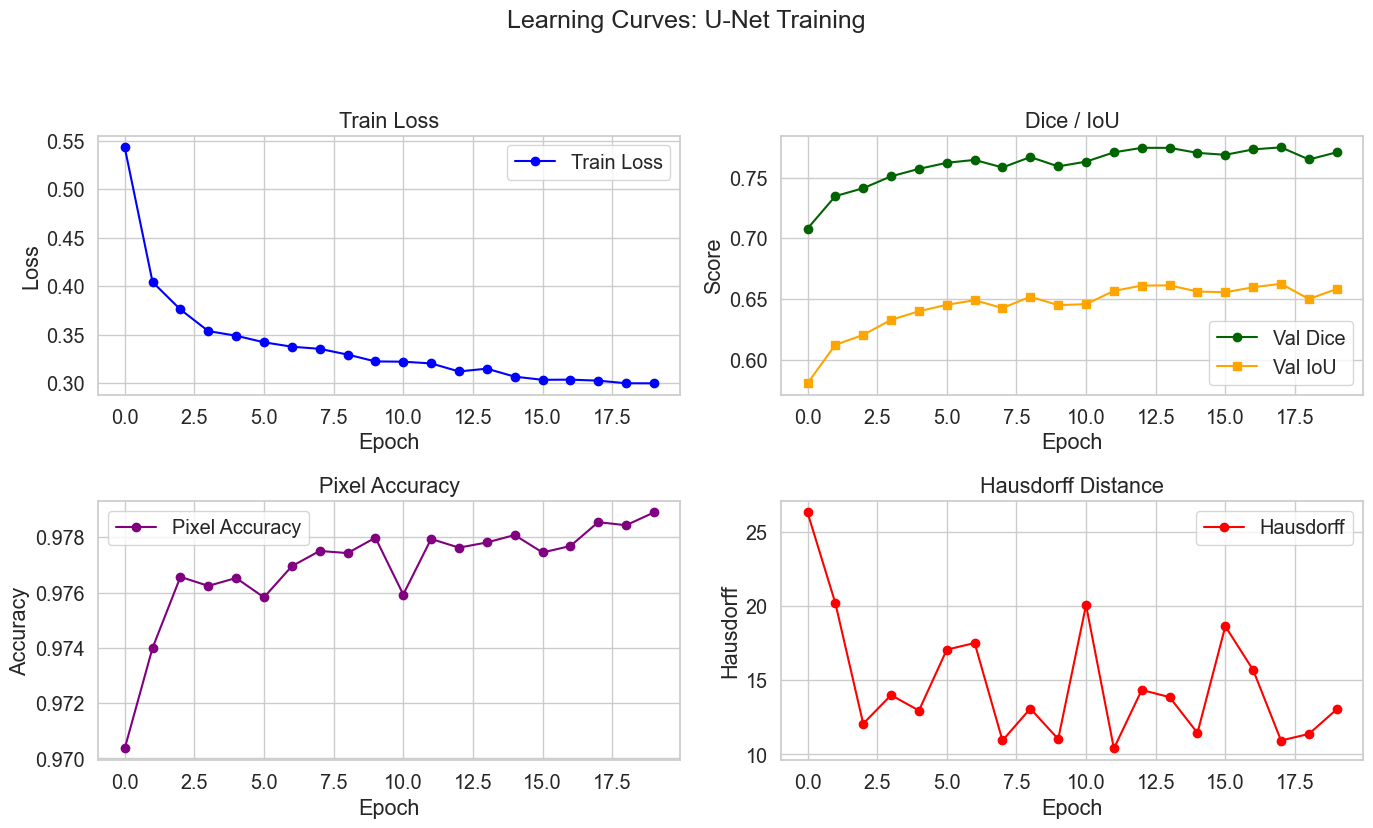

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)

with open("training_history.pkl", "rb") as f:
    history = pickle.load(f)

plt.figure(figsize=(14, 8))

plt.subplot(2,2,1)
plt.plot(history['train_loss'], marker='o', label="Train Loss", color='blue')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train Loss")
plt.legend(); plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history['val_dice'], marker='o', label="Val Dice", color='darkgreen')
plt.plot(history['val_iou'], marker='s', label="Val IoU", color='orange')
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Dice / IoU")
plt.legend(); plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history['val_acc'], marker='o', label="Pixel Accuracy", color='purple')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Pixel Accuracy")
plt.legend(); plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history['val_hausdorff'], marker='o', label="Hausdorff", color='red')
plt.xlabel("Epoch"); plt.ylabel("Hausdorff"); plt.title("Hausdorff Distance")
plt.legend(); plt.grid(True)

plt.suptitle("Learning Curves: U-Net Training", fontsize=18, y=1.04)
plt.tight_layout()
plt.savefig("training_curves_presentation.png", dpi=200)
plt.show()


In [ ]:
import torch
import numpy as np
from PIL import Image, ImageOps
from torchvision import transforms as T

def pad_to_multiple(img, mult=16):
    w, h = img.size
    pad_w = (mult - w % mult) if w % mult != 0 else 0
    pad_h = (mult - h % mult) if h % mult != 0 else 0
    if pad_w != 0 or pad_h != 0:
        img = ImageOps.expand(img, border=(0, 0, pad_w, pad_h), fill=0)
    return img, (pad_w, pad_h)

def predict_full_image_square(model, image_path, mult=16):
    model.eval()
    device = next(model.parameters()).device
    full_img = Image.open(image_path).convert("L")
    orig_width, orig_height = full_img.size
    square_size = orig_width
    num_squares = orig_height // square_size
    remainder = orig_height % square_size
    total_height = num_squares * square_size + (square_size if remainder else 0)
    pad_h = 0
    if total_height > orig_height:
        pad_h = total_height - orig_height
        full_img = ImageOps.expand(full_img, border=(0, 0, 0, pad_h), fill=0)
    mask = np.zeros((total_height, orig_width), dtype=np.float32)
    for i in range(0, total_height, square_size):
        patch = full_img.crop((0, i, orig_width, i + square_size))
        patch_padded, (pw, ph) = pad_to_multiple(patch, mult=mult)
        patch_tensor = T.ToTensor()(patch_padded).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_patch = model(patch_tensor)
        pred_patch = pred_patch.cpu().numpy().squeeze()
        pred_patch = pred_patch[:patch.size[1], :patch.size[0]]  
        mask[i:i + square_size, :] = pred_patch
    mask = mask[:orig_height, :orig_width]
    return mask

class DoubleConv(torch.nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, 3, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(out_c, out_c, 3, padding=1), torch.nn.ReLU())
    def forward(self, x): return self.conv(x)

class UNet(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.conv1 = DoubleConv(in_channels, 32)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        self.conv4 = DoubleConv(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        self.up3 = torch.nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv_up3 = DoubleConv(256, 128)
        self.up2 = torch.nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv_up2 = DoubleConv(128, 64)
        self.up1 = torch.nn.ConvTranspose2d(64, 32, 2, 2)
        self.conv_up1 = DoubleConv(64, 32)
        self.out_conv = torch.nn.Conv2d(32, out_channels, 1)
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv_up3(x)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv_up2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv_up1(x)
        return torch.sigmoid(self.out_conv(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load("best_model1.pth", map_location=device))
model.eval()

full_image_path = "1.png"  
predicted_mask = predict_full_image_square(model, full_image_path, mult=16)
predicted_mask_bin = (predicted_mask >= 0.5).astype(np.uint8) * 255
Image.fromarray(predicted_mask_bin).save("segmentation_result_full.png")
print("Готово! Результат сохранён в segmentation_result_full.png")